In [1]:
import json
import pytorch_lightning as pl
from einops import rearrange
import torch
import torchaudio
from torch.utils.data import DataLoader
import safetensors
from safetensors.torch import load_file
import random


import shutil
from collections import OrderedDict
from datetime import datetime
import os
import torch.nn.functional as F

from stable_audio_tools import create_model_from_config, replace_audio, save_audio
from stable_audio_tools.data.dataset import VideoFeatDataset, VideoFeatDataset_VL, collation_fn
from stable_audio_tools.training.training_wrapper import DiffusionCondTrainingWrapper
from stable_audio_tools.inference.generation import generate_diffusion_cond, generate_diffusion_cond_from_path


# model_config_file = './stable_audio_tools/configs/model_config_gc16000.json'
model_config_file = './stable_audio_tools/configs/model_config_vl30.json'
# model_config_file = './stable_audio_tools/configs/model_config_vl30_rotebd.json'
# model_config_file = './stable_audio_tools/configs/model_config_ss30.json'


with open(model_config_file) as f:
    model_config = json.load(f)
    sample_rate = model_config["sample_rate"]
    sample_size = model_config["sample_size"]
    fps = model_config["fps"]
    variable_length = model_config["variable_length"]
    force_channels = "stereo" if model_config["audio_channels"] == 2 else "mono"


model = create_model_from_config(model_config)
sample_size, sample_rate, sample_size/sample_rate, variable_length, fps, force_channels

/home/chengxin/chengxin/anaconda3/envs/stableaudio/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'flash_attn_2_cuda' from '/home/chengxin/chengxin/anaconda3/envs/stableaudio/lib/python3.8/site-packages/flash_attn_2_cuda.cpython-38-x86_64-linux-gnu.so'>
cannot import name 'DISABLE' from 'flash_attn' (/home/chengxin/chengxin/anaconda3/envs/stableaudio/lib/python3.8/site-packages/flash_attn/__init__.py)
flash_attn not installed, disabling Flash Attention


(1323000, 44100, 30.0, 30, 8, 'stereo')

In [2]:
import safetensors.torch

model_dir = './weight/StableAudio/2024-08-04 02:52:24'
model_name = 'epoch=60-step=2818'  
# ./weight/StableAudio/lightning_logs/version_3/checkpoints  epoch=9-step=14620                                     FPS=22  config
# ./weight/StableAudio/2024-07-06 10:28:13               在basemodel的基础上 加入pos_emb,利用AS进行训练<epoch=30-step=58>   time_align和生成效果表现较好(best)   FPS=22 config
# ./weight/StableAudio/2024-07-20 13:34:51               在basemodel的基础上 加入pos_emb 利用VGG重新训练 epoch=3-step=1817                          FPS=22  config
# ./weight/StableAudio/2024-07-22 19:08:45               在不load t2a-crosscond&conditioner的基础上 加入rotary_cond_emb 利用AS重新训练              FPS=8 sr=16000  config_rotebd
# ./weight/StableAudio/2024-07-24 23:06:33               在bestmodel的基础上    利用AS继续进行训练     <epoch=70-step=304> <epoch=150-step=304>     FPS=22  config
# ./weight/StableAudio/2024-08-01 09:36:20               在lastmodel<epoch=70-step=304>的基础上    利用ASVGG继续进行训练   <epoch=45-step=2818>  <epoch=29-step=2818>    FPS=22  config
# ./weight/StableAudio/2024-08-04 02:52:24               在lastmodel<epoch=29-step=2818>的基础上    利用ASVGG继续进行训练  <epoch=27-step=2818> <epoch=36-step=2818> <epoch=60-step=2818>
# ./weight/StableAudio/2024-08-15 11:31:46               在lastmodel<epoch=36-step=2818>的基础上 加入global_cond_ids ["seconds_start", "seconds_total"] samplesize44100*30 variablelength30
# ./weight/StableAudio/2024-08-19 11:11:56               在lastmodel<epoch=36-step=2818>, sr16000 ss160000 fps8 noclamp  加入global_cond_ids 利用VGG继续进行训练   <epoch=60-step=2818> <epoch=30-step=2818> <epoch=35-step=2818> 

try:
    state_dict = load_file(f'{model_dir}/{model_name}.safetensors')
except:
    state_dict = torch.load(f'{model_dir}/{model_name}.ckpt')['state_dict']
    state_dict = OrderedDict([(".".join(key.split('.')[1:]), value)  for key, value in state_dict.items()])
    safetensors.torch.save_file(state_dict, f'{model_dir}/{model_name}.safetensors')

print(f'{model_dir}/{model_name}.safetensors')

# cond_state_dict = load_file(f'./weight/StableAudio/model.safetensors')
# cond_state_dict = {k: v for k, v in cond_state_dict.items() if ('seconds' in k)}
# state_dict.update(cond_state_dict)
model.load_state_dict(state_dict, strict=False)

./weight/StableAudio/2024-08-04 02:52:24/epoch=60-step=2818.safetensors


<All keys matched successfully>

In [3]:
from moviepy.editor import VideoFileClip, AudioFileClip
import time


device = 1
# video_path = '/home/chengxin/chengxin/VGGSound/dataset/test/10/A6_Rikjub4o_000032.mp4' ## 指环王
# video_path = '/home/chengxin/chengxin/VGGSound/dataset/test/10/3lkI_scF2eU_000130.mp4' ## 狗人
video_path = '/home/chengxin/chengxin/VGGSound/dataset/test/10/__2MwJ2uHu0_000004.mp4' ## 拉二胡

conditioning = {
    'seconds_start': [0],
    'seconds_total': [10],
    # 'feature': ['/home/chengxin/chengxin/VGGSound/dataset/test/10/A6_Rikjub4o_000032.mp4'], ## 指环王
    # 'feature': ['/home/chengxin/chengxin/VGGSound/dataset/test/10/3lkI_scF2eU_000130.mp4'], ## 
    'feature': [video_path] ## 拉二胡
}
video_clip = VideoFileClip(conditioning['feature'][0])
seconds_total = int(video_clip.duration)

output = generate_diffusion_cond(
    model = model.to(device),
    steps=150,
    cfg_scale=7,
    conditioning=conditioning,
    sample_size=int(sample_rate*seconds_total),
    batch_size=len(conditioning['feature']),
    sigma_min=0.3,
    sigma_max=500,
    sampler_type="dpmpp-3m-sde",
    device=device,
    seed = 3739408088,
    return_map=True
)


if type(output) == tuple:
    output, timestep_attn_maps = output

audio_path = "./test.wav"
waveform = output[0:1,...,:int(seconds_total*sample_rate)]
# print(output.shape, output[idx:idx+1].shape, waveform.shape)
save_audio(waveform, audio_path, sample_rate)


3739408088
Extracting features from video:/home/chengxin/chengxin/VGGSound/dataset/test/10/__2MwJ2uHu0_000004.mp4


100%|██████████| 150/150 [00:05<00:00, 25.37it/s]


In [5]:
layer_idx = 145
time_step_idx = 23


results = torch.concat([i for i in timestep_attn_maps[time_step_idx]])
# results = torch.concat([i[layer_idx] for i in timestep_attn_maps])
# results = timestep_attn_maps[time_step_idx][layer_idx]


attention_weights = results.sum(0) / (results.sum()/results.shape[1])

attention_weights = attention_weights
results.shape, attention_weights.shape, attention_weights[:10].shape, attention_weights[:10].sum()

(torch.Size([48, 216, 220]),
 torch.Size([216, 220]),
 torch.Size([10, 220]),
 tensor(10., device='cuda:0'))

In [5]:
# attention_weights = attention_weights[1:,1:]
# attention_weights = (attention_weights/attention_weights.sum(0)).softmax(dim = 0)
# attention_weights[:,0].shape, attention_weights[:,:10].sum(), attention_weights.shape, attention_weights.sum(-1).shape

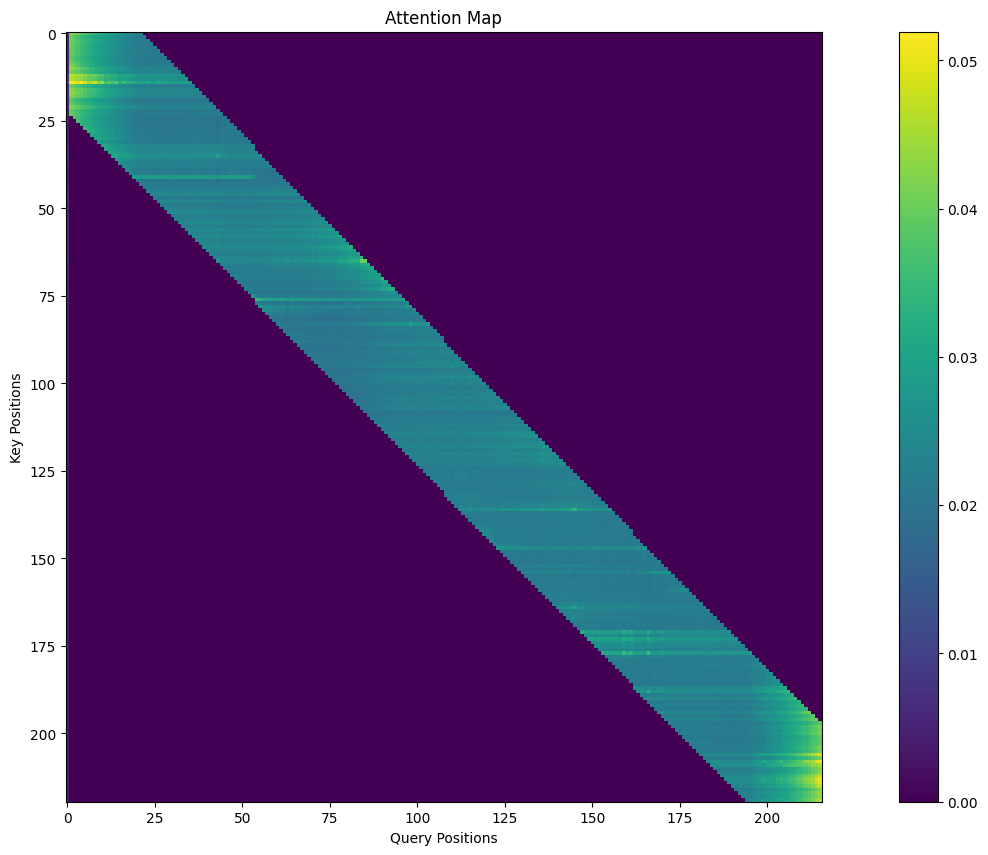

: 

In [6]:
import matplotlib.pyplot as plt
import numpy as np


# 绘制注意力图
plt.figure(figsize=(20, 10))
plt.imshow(attention_weights.T.cpu(), cmap='viridis')
plt.colorbar()
plt.xlabel('Query Positions')
plt.ylabel('Key Positions')
plt.title('Attention Map')
plt.show()